In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
%cd /content/drive/MyDrive/imt/semestre4/Computational imaging/image-segmentation
#%cd /content/drive/MyDrive/imt/semestre4/Computational imaging/image-segmentation
%ls images/soccer/

/content/drive/MyDrive/imt/semestre4/Computational imaging/image-segmentation
soccerGT.jpg   soccer.jpg        soccer_seg.npz
soccer_gt.npz  soccerseeded.jpg  soccer_term.npz


In [3]:
def DICE_assessment(groundtruth, estimated, label=255):
    A = groundtruth == label
    B = estimated == label              
    TP = len(np.nonzero(A*B)[0])
    FN = len(np.nonzero(A*(~B))[0])
    FP = len(np.nonzero((~A)*B)[0])
    DICE = 0
    if (FP+2*TP+FN) != 0: 
        DICE = float(2)*TP/(FP+2*TP+FN)
    return DICE*100

# Min-cut Graph solving 

In [4]:
import time
from __future__ import division
import cv2
import numpy as np
import os
import sys
import argparse
from math import exp, pow
from augmentingPath import augmentingPath
from pushRelabel import pushRelabel
from boykovKolmogorov import KolmogorovSolver
from matplotlib import pyplot as plt

from skimage import filters

# np.set_printoptions(threshold=np.inf)
graphCutAlgo = {"ap": augmentingPath, 
                "pr": pushRelabel
                }



def segmentationTest(filename,shape, algo="bk",alpha=1.0,link_sigma=30,filter_sigma=0.7):
  #SIGMA = 30
  # LAMBDA = 1
  #OBJCOLOR, BKGCOLOR = (0, 0, 255), (0, 255, 0)
  OBJCODE, BKGCODE = 1, 2
  #OBJ, BKG = "OBJ", "BKG"

  CUTCOLOR = (0, 0, 255)
  SEGCOLOR = (0, 0, 255)

  #SOURCE, SINK = -2, -1
  Terminals={"s":-2,"t":-1}
  #SF = 10
  #LOADSEEDS = False
  # drawing = False

  # Large when ip - iq < sigma, and small otherwise
  def boundaryPenalty(ip, iq,SIGMA=link_sigma):
      bp = 100 * exp(- pow(int(ip) - int(iq), 2) / (2 * pow(SIGMA, 2)))
      return bp

  def buildGraph(image,seeds,pathname):
      V = image.size + 2
      graph = np.zeros((V, V), dtype='int32')
      #image=(filters.gaussian(image,sigma=0.2)*255)
      K = makeNLinks(graph, image)
      #seeds, seededImage = plantSeed(image)
      
      makeTLinks(graph, seeds, K)
      return graph

  def addSegment(graph,x,y,val):
      graph[x][y] = val
      graph[y][x] = val

  def addTlinks(graph,seeds,i,j,nodeid,val):
      if seeds[i][j] == OBJCODE:
          # graph[x][source] = K
          graph[Terminals["s"]][nodeid] = val*alpha
      elif seeds[i][j] == BKGCODE:
          graph[nodeid][Terminals["t"]] = val*alpha

  def makeNLinks(graph, image):
      
      #K=-float("inf")
      r, c = image.shape
      K = np.ones((r,c))*(-float("inf"))
      for i in range(r):
          for j in range(c):
              x = i * c + j
              if i + 1 < r: # pixel below
                  y = (i + 1) * c + j
                  bp = boundaryPenalty(image[i][j], image[i + 1][j])
                  addSegment(graph,x,y,bp)
                  #K = max(K, bp)
                  K[i,j] = max(K[i,j], bp)
 
              if j + 1 < c: # pixel to the right
                  y = i * c + j + 1
                  bp = boundaryPenalty(image[i][j], image[i][j + 1])
                  addSegment(graph,x,y,bp)
                  #K = max(K, bp)
                  K[i,j] = max(K[i,j], bp)

              if i - 1 >= 0: # pixel to the right
                  y = (i-1) * c + j 
                  bp = boundaryPenalty(image[i][j], image[i-1][j])
                  addSegment(graph,x,y,bp)
                  #K = max(K, bp)
                  K[i,j] = max(K[i,j], bp)

              if j - 1 >= 0: # pixel to the right
                  y = i * c + j - 1
                  bp = boundaryPenalty(image[i][j], image[i][j - 1])
                  addSegment(graph,x,y,bp)
                  #K = max(K, bp)
                  K[i,j] = max(K[i,j], bp)
              
      return K



  def makeTLinks(graph, seeds, K):
      r, c = seeds.shape

      for i in range(r):
          for j in range(c):
              x = i * c + j

              addTlinks(graph,seeds,i,j,x,K[i,j])
                  # graph[sink][x] = K
              # else:
              #     graph[x][source] = LAMBDA * regionalPenalty(image[i][j], BKG)
              #     graph[x][sink]   = LAMBDA * regionalPenalty(image[i][j], OBJ)



  def displaySegmentationBK(image, solver):


      r, c = image.shape
      image = cv2.cvtColor(image, cv2.COLOR_GRAY2RGB)
      cut_array=np.zeros((r,c))
      for i in range(solver.Nvertex-2):
              if solver.Tree[i]==1:
                  ix=int(i%c)
                  iy=int(i/c)
                  image[iy][ix]=SEGCOLOR
                  cut_array[iy][ix] = 1
      
      return image,cut_array

  def displaySegmentationPR(image, segmentation):


      r, c = image.shape
      print(image.shape)
      image = cv2.cvtColor(image, cv2.COLOR_GRAY2RGB)
      cut_array=np.zeros((r,c))
      #print(SOURCE)
      #print(SINK)
      for i in segmentation:
        if i!= Terminals["s"] and i!= Terminals["t"]:

                  ix=int(i%c)
                  iy=int(i/c)
                  image[iy][ix]=SEGCOLOR
                  cut_array[iy][ix] = 1
      
      return image,cut_array

  def displaySegmentation(image, cuts):
      def colorPixel(i, j):
          image[i][j] = CUTCOLOR

      r, c = image.shape
      image = cv2.cvtColor(image, cv2.COLOR_GRAY2RGB)
      for c in cuts:
          if c[0] != Terminals["s"] and c[0] != Terminals["t"] and c[1] != Terminals["s"] and c[1] != Terminals["t"]:
              colorPixel(c[0] // r, c[0] % r)
              colorPixel(c[1] // r, c[1] % r)
      return image
      


  def imageSegmentation(pathname,image, seeds,size, algo="bk"):
      #pathname = os.path.splitext(imagefile)[0]
      #image = cv2.imread(imagefile, cv2.IMREAD_GRAYSCALE)
      time_algo=0
      #global SOURCE, SINK
      Terminals["s"], Terminals["t"] = -2, -1
      image = cv2.resize(image, size)
      graph = buildGraph(image,seeds,pathname)
      print("graph shape:",graph.shape)

      

      Terminals["s"] += graph.shape[0]
      Terminals["t"]   += graph.shape[0]
      if algo=="bk":
        start_time = time.clock()
        solver = KolmogorovSolver(graph, Terminals["s"], Terminals["t"])
        solver.Kolmogorov()
        time_algo=time.clock() - start_time
        image,cutarray = displaySegmentationBK(image, solver)
      elif algo=="pr":
        start_time = time.clock()
        segs = pushRelabel(np.asarray(graph), Terminals["s"], Terminals["t"])
        time_algo=time.clock() - start_time

        image,cutarray = displaySegmentationPR(image, segs)


      #cuts = graphCutAlgo[algo](graph, SOURCE, SINK)
      #print("cuts:")
      #print(cuts)

      #cuts=solver.cuts
      #print("maxflow")
      #print(solver.maxflow)
      #print ("cuts:")
      #print (cuts)
      
      np.savez(pathname + "_seg", cutarray)
      #image = cv2.resize(image, (0, 0), fx=SF, fy=SF)

      return image,time_algo
      


    


  pathname = os.path.splitext(filename)[0]
  print("starting processing with shape %s %s"% (shape[0],shape[1]))
  orig_image=cv2.imread(pathname+".jpg", cv2.IMREAD_GRAYSCALE)
  orig_image=(filters.gaussian(orig_image,sigma=filter_sigma)*255).astype(np.uint8)
  print(type(orig_image[0,0]))
  orig_image=cv2.resize(orig_image,shape)
  seeded_image=cv2.resize(cv2.imread(pathname +"seeded.jpg"),shape)
  gt_image=cv2.resize(cv2.imread(pathname +"GT.jpg"),shape)
  gt=cv2.resize(np.load(pathname + "_gt.npz")['arr_0'],shape,shape,interpolation = cv2.INTER_NEAREST)
  seeds=cv2.resize(np.load(pathname + "_term.npz")['arr_0'],shape,shape,interpolation = cv2.INTER_NEAREST)

  img_seg,time_algo=imageSegmentation(pathname,orig_image,seeds, (shape[0], shape[1]), algo)


  seg=np.load(pathname + "_seg.npz")['arr_0']

  return orig_image,seeded_image,gt_image,gt,img_seg,seg,time_algo





In [5]:
def speedTest(filename,algo="bk",trange=range(1,10)):
  res=[]
  for i in trange:
    print(i)
    orig_image,seeded_image,gt_image,gt,img_seg,seg,time_algo=segmentationTest(filename,(i,i),algo=algo)
    res.append(time_algo)
  return res
  



In [6]:
def processTestResults(orig_image,seeded_image,gt_image,gt,img_seg,seg,time_algo):

  dice =DICE_assessment(gt, seg, label=1)
  plt.figure(figsize=(13,13))

  #plt.imshow((filters.gaussian(orig_image)*255))
  print("Running time: %s"%time_algo)
  print("Dice: %s"%dice)


  plt.subplot(221)
  plt.imshow(orig_image)
  plt.title("Original image")

  plt.subplot(222)
  plt.imshow(seeded_image)
  plt.title("Seeded image")

  plt.subplot(223)
  plt.imshow(gt_image)
  plt.title("Ground truth segmentation")

  plt.subplot(224)
  plt.imshow(img_seg)
  
  plt.title("Processed segmentation")
  plt.show()

  return dice



## Circle test

starting processing with shape 60 60
<class 'numpy.uint8'>
graph shape: (3602, 3602)


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:183: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead


Ruunning Kolmogorov solver


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:186: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead


Running time: 11.063666000000001
Dice: 98.29571625978811


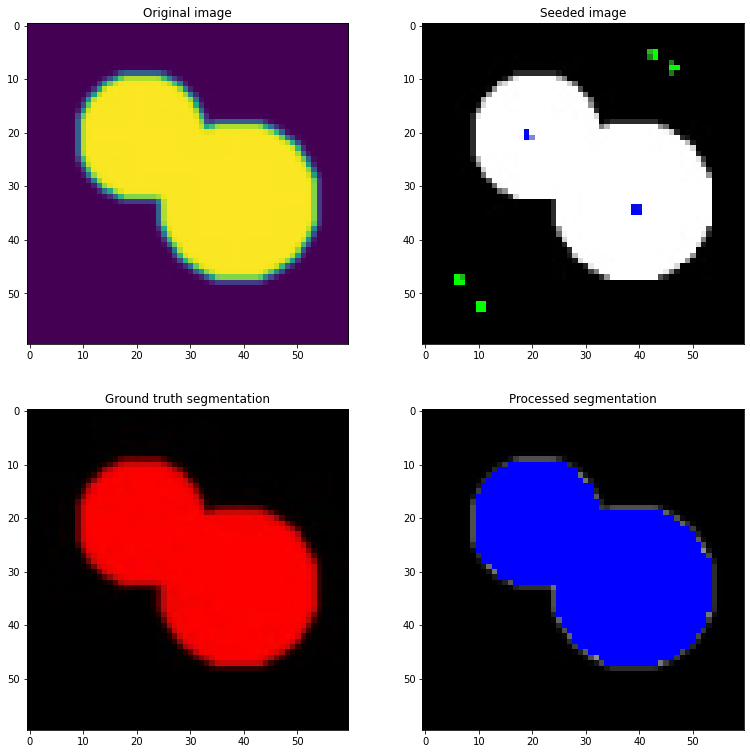

In [7]:
orig_image,seeded_image,gt_image,gt,img_seg,seg,time_algo=segmentationTest("images/circle/circle.jpg",(60,60),algo="bk",link_sigma=30,alpha=100)
circle_maxflow_dice=processTestResults(orig_image,seeded_image,gt_image,gt,img_seg,seg,time_algo)

## Soccer Ball test

starting processing with shape 60 60
<class 'numpy.uint8'>
graph shape: (3602, 3602)
Ruunning Kolmogorov solver


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:183: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:186: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead


Running time: 16.676592
Dice: 91.1890504704876


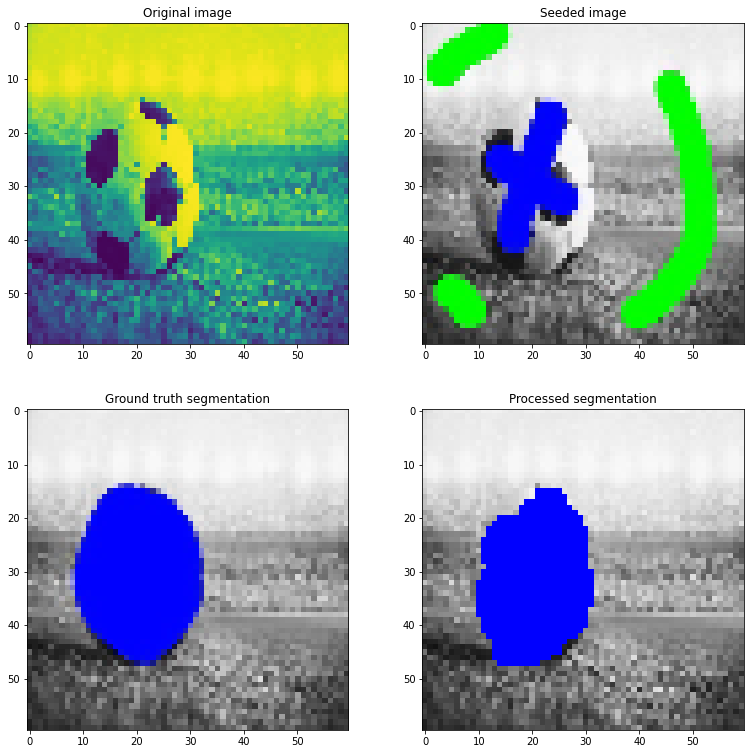

In [8]:
orig_image,seeded_image,gt_image,gt,img_seg,seg,time_algo=segmentationTest("images/soccer/soccer.jpg",(60,60),algo="bk",link_sigma=30,alpha=100)
soccer_maxflow_dice=processTestResults(orig_image,seeded_image,gt_image,gt,img_seg,seg,time_algo)

## Horse test

### Lower alpha

starting processing with shape 60 60
<class 'numpy.uint8'>
graph shape: (3602, 3602)


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:183: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead


Ruunning Kolmogorov solver


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:186: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead


Running time: 18.21095299999996
Dice: 86.02739726027397


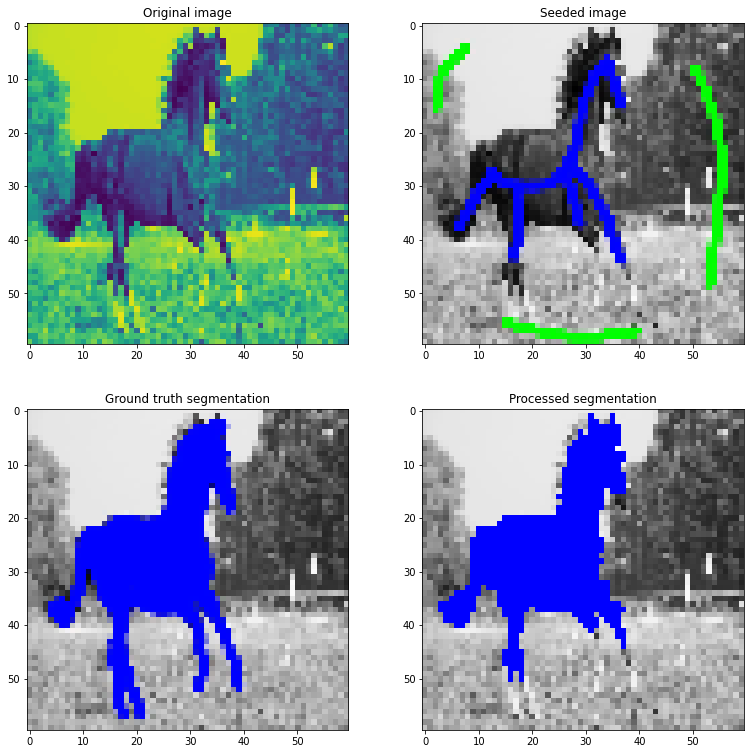

In [15]:
orig_image,seeded_image,gt_image,gt,img_seg,seg,time_algo=segmentationTest("images/horse/horse.jpg",(60,60),algo="bk",link_sigma=30,alpha=0.3)
horse_maxflow_dice=processTestResults(orig_image,seeded_image,gt_image,gt,img_seg,seg,time_algo)

### Higher sigma

starting processing with shape 60 60
<class 'numpy.uint8'>
graph shape: (3602, 3602)


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:183: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead


Ruunning Kolmogorov solver


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:186: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead


Running time: 29.68077999999997
Dice: 83.85382059800665


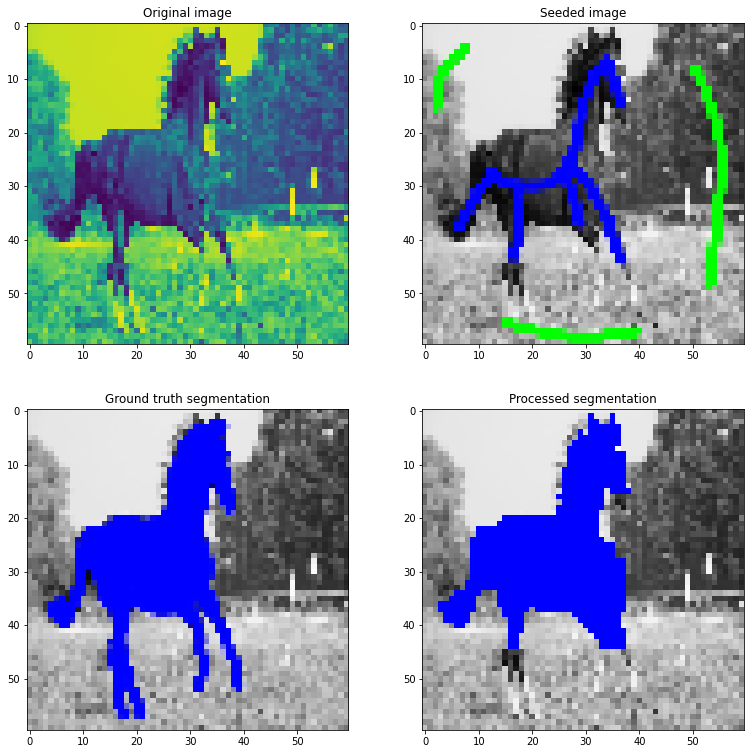

In [17]:
orig_image,seeded_image,gt_image,gt,img_seg,seg,time_algo=segmentationTest("images/horse/horse.jpg",(60,60),algo="bk",link_sigma=50,alpha=1.0)
horse_maxflow_dice=processTestResults(orig_image,seeded_image,gt_image,gt,img_seg,seg,time_algo)

### Lower sigma

starting processing with shape 60 60
<class 'numpy.uint8'>
graph shape: (3602, 3602)


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:183: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead


Ruunning Kolmogorov solver


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:186: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead


Running time: 10.673226999999997
Dice: 78.05171377029465


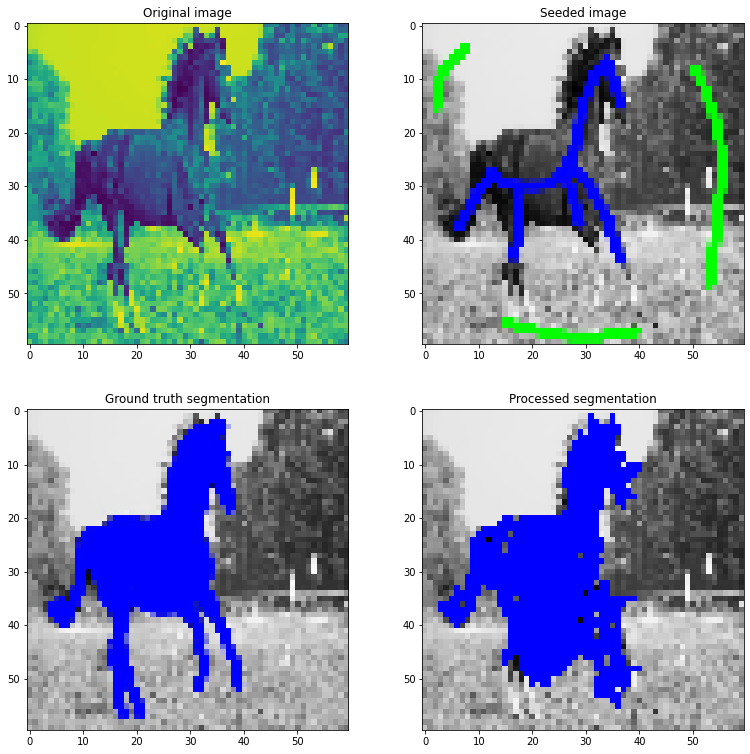

In [18]:
orig_image,seeded_image,gt_image,gt,img_seg,seg,time_algo=segmentationTest("images/horse/horse.jpg",(60,60),algo="bk",link_sigma=10,alpha=1.0)
horse_maxflow_dice=processTestResults(orig_image,seeded_image,gt_image,gt,img_seg,seg,time_algo)

starting processing with shape 60 60
<class 'numpy.uint8'>
graph shape: (3602, 3602)


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:183: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead


Ruunning Kolmogorov solver


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:186: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead


Running time: 19.14885800000002
Dice: 86.57314629258516


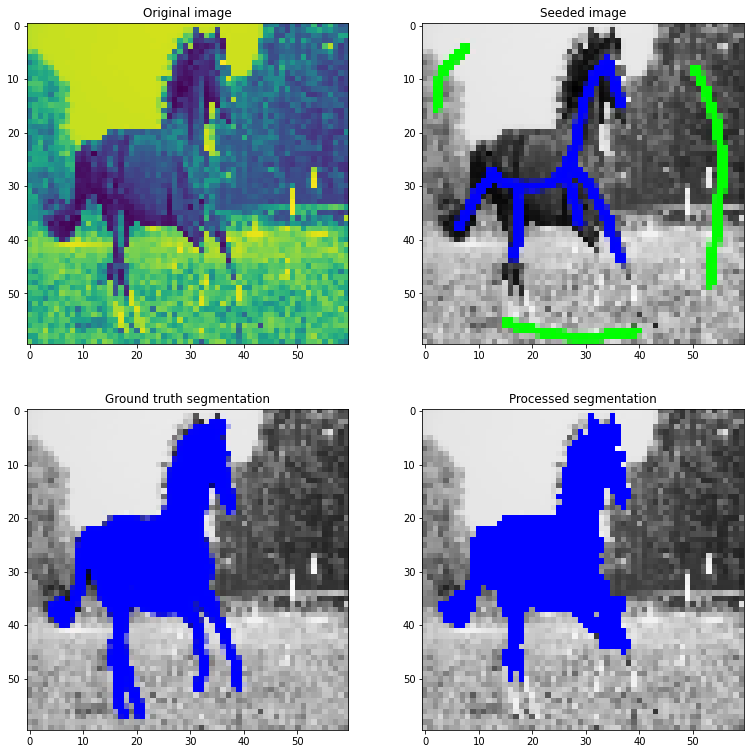

In [14]:
orig_image,seeded_image,gt_image,gt,img_seg,seg,time_algo=segmentationTest("images/horse/horse.jpg",(60,60),algo="bk",link_sigma=30,alpha=100)
horse_maxflow_dice=processTestResults(orig_image,seeded_image,gt_image,gt,img_seg,seg,time_algo)

### Higher resolution

starting processing with shape 100 100
<class 'numpy.uint8'>
graph shape: (10002, 10002)


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:183: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead


Ruunning Kolmogorov solver


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:186: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead


Running time: 355.746366
Dice: 86.72401767030922


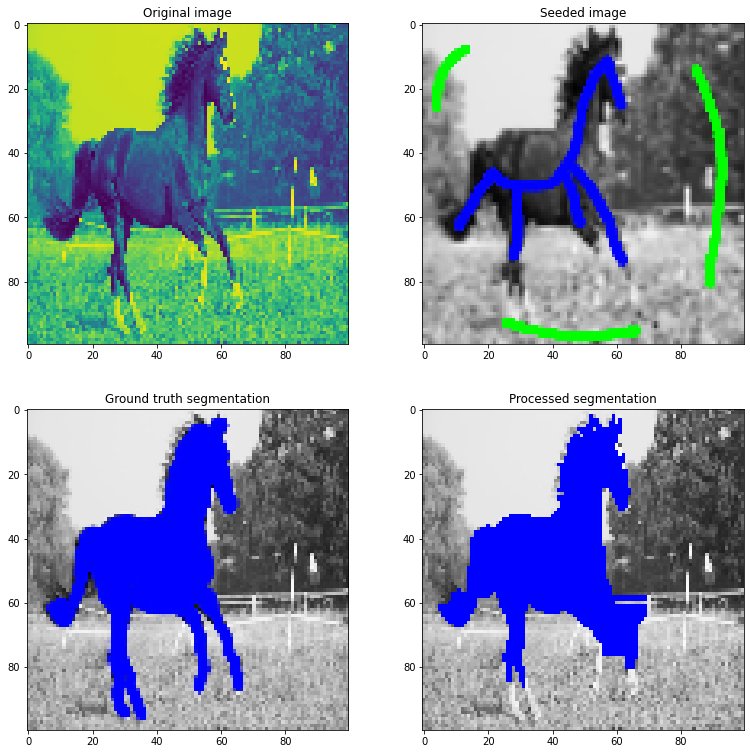

In [13]:
orig_image,seeded_image,gt_image,gt,img_seg,seg,time_algo=segmentationTest("images/horse/horse.jpg",(100,100),algo="bk",link_sigma=30,alpha=100)
horse_maxflow_dice=processTestResults(orig_image,seeded_image,gt_image,gt,img_seg,seg,time_algo)

## Runtime speed test

In [ ]:
trange=range(2,10)
bk_soccer_res=speedTest("images/soccer/soccer.jpg",algo="bk",trange=trange)
pr_soccer_res=speedTest("images/soccer/soccer.jpg",algo="pr",trange=trange)
trange_big=range(2,30)
bk_soccer_res_big=speedTest("images/soccer/soccer.jpg",algo="bk",trange=trange_big)
bk_horse_res_big=speedTest("images/horse/horse.jpg",algo="bk",trange=trange_big)
bk_circle_res_big=speedTest("images/circle/circle.jpg",algo="bk",trange=trange_big)

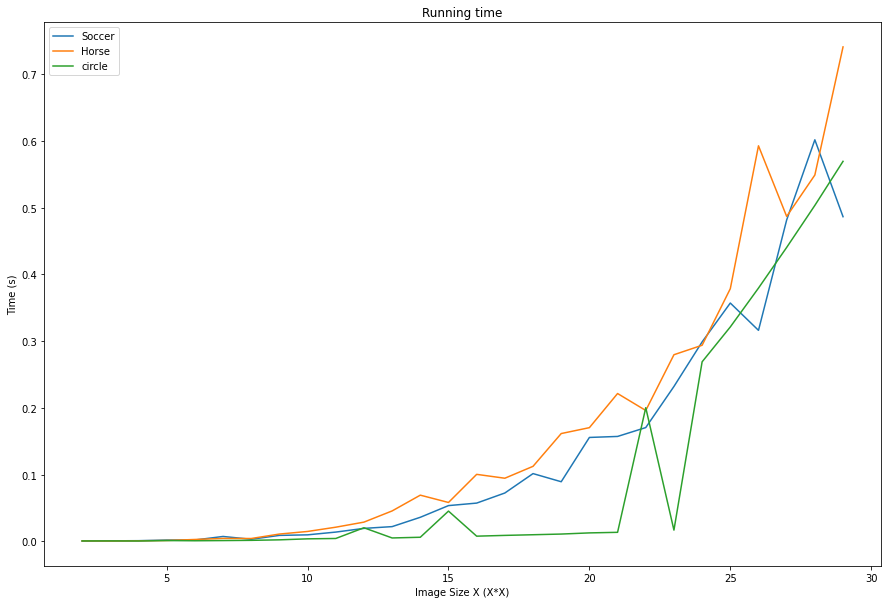

In [11]:
plt.figure(figsize=(15,10))
plt.plot(trange_big,bk_soccer_res_big,label="Soccer")
plt.plot(trange_big,bk_horse_res_big,label="Horse")
plt.plot(trange_big,bk_circle_res_big,label="circle")
plt.title("Running time")
plt.ylabel('Time (s)')
plt.xlabel("Image Size X (X*X)")
plt.legend()

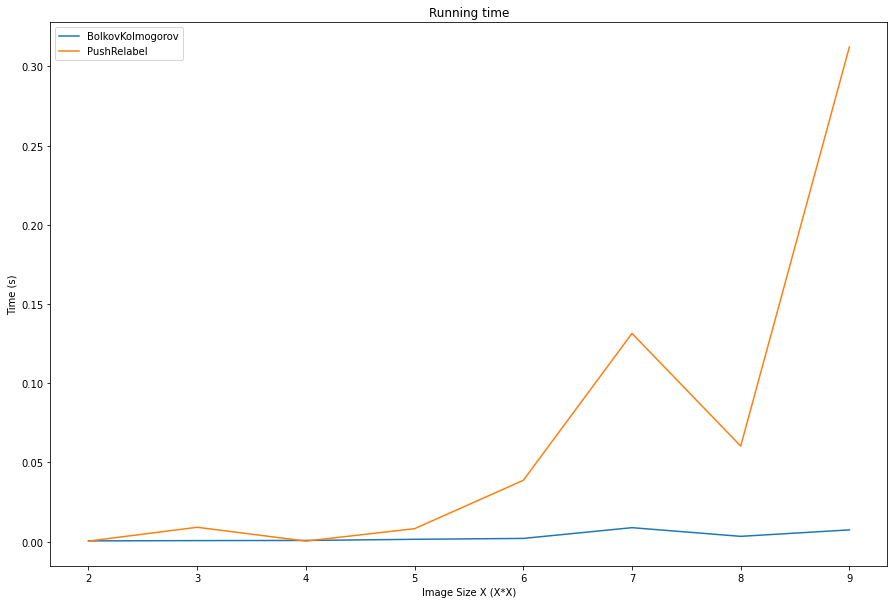

In [12]:
plt.figure(figsize=(15,10))
plt.plot(trange,bk_soccer_res,label="BolkovKolmogorov")
plt.plot(trange,pr_soccer_res,label="PushRelabel")
plt.title("Running time")
plt.ylabel('Time (s)')
plt.xlabel("Image Size X (X*X)")
plt.legend()

# Watershed Algorithm

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from scipy import ndimage as ndi

from skimage.segmentation import watershed
from skimage.feature import peak_local_max




In [ ]:
def clrShedProcess(filename,shape,filter_sigma=0.01):
  pathname = os.path.splitext(filename)[0]
  print("starting processing with shape %s %s"% (shape[0],shape[1]))
  #orig_image=cv2.imread(pathname+".jpg", cv2.IMREAD_GRAYSCALE)
  orig_image=cv2.imread(pathname+".jpg")
  orig_image=(filters.gaussian(orig_image,sigma=filter_sigma)*255).astype(np.uint8)
  print(type(orig_image[0,0]))
  orig_image=np.uint8(cv2.resize(orig_image,shape))
  seeded_image=cv2.resize(cv2.imread(pathname +"seeded.jpg"),shape)
  gt_image=cv2.resize(cv2.imread(pathname +"GT.jpg"),shape)
  gt=cv2.resize(np.load(pathname + "_gt.npz")['arr_0'],shape,shape,interpolation = cv2.INTER_NEAREST)
  seeds=np.int32( cv2.resize(np.load(pathname + "_term.npz")['arr_0'],shape,interpolation = cv2.INTER_NEAREST))

  time_algo=0
  markers=seeds
  markers[markers==0]=-1
  #img_seg,time_algo=imageSegmentation(pathname,orig_image,seeds, (shape[0], shape[1]), algo)
  seg = cv2.watershed(orig_image,markers).astype(float)
  img_seg=orig_image.copy()
  img_seg[seg==1]=(255,0,0)

  #seg=np.load(pathname + "_seg.npz")['arr_0']

  return orig_image,seeded_image,gt_image,gt,img_seg,seg,time_algo

## Circle test

starting processing with shape 80 80
<class 'numpy.ndarray'>
Running time: 0
Dice: 98.37526205450735


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:6: RuntimeWarning: Images with dimensions (M, N, 3) are interpreted as 2D+RGB by default. Use `multichannel=False` to interpret as 3D image with last dimension of length 3.
  


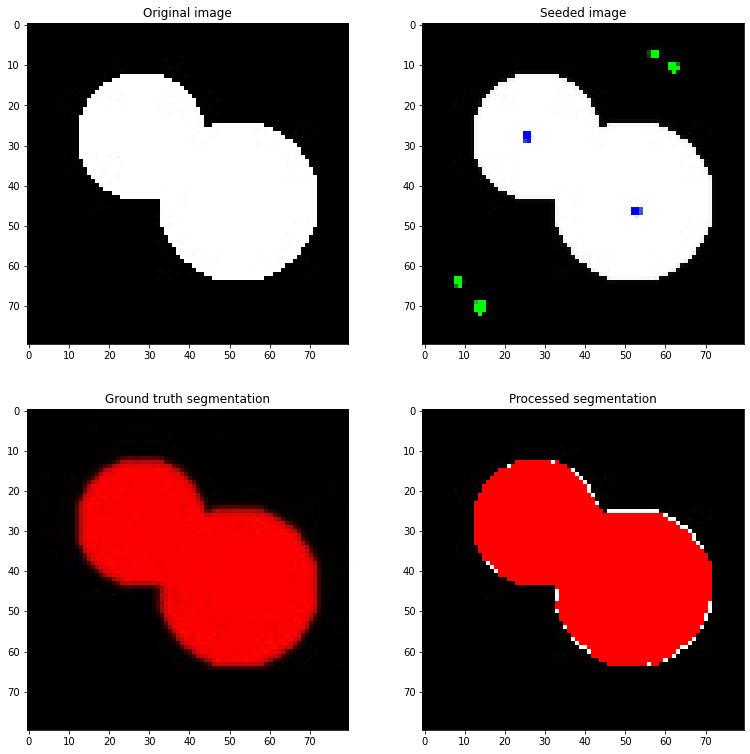

In [ ]:
orig_image,seeded_image,gt_image,gt,img_seg,seg,time_algo=clrShedProcess("images/circle/circle.jpg",(80,80),filter_sigma=0.01)
circle_water_dice=processTestResults(orig_image,seeded_image,gt_image,gt,img_seg,seg,time_algo)

## Soccer Ball Test

starting processing with shape 80 80
<class 'numpy.ndarray'>
Running time: 0
Dice: 78.996138996139


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:6: RuntimeWarning: Images with dimensions (M, N, 3) are interpreted as 2D+RGB by default. Use `multichannel=False` to interpret as 3D image with last dimension of length 3.
  


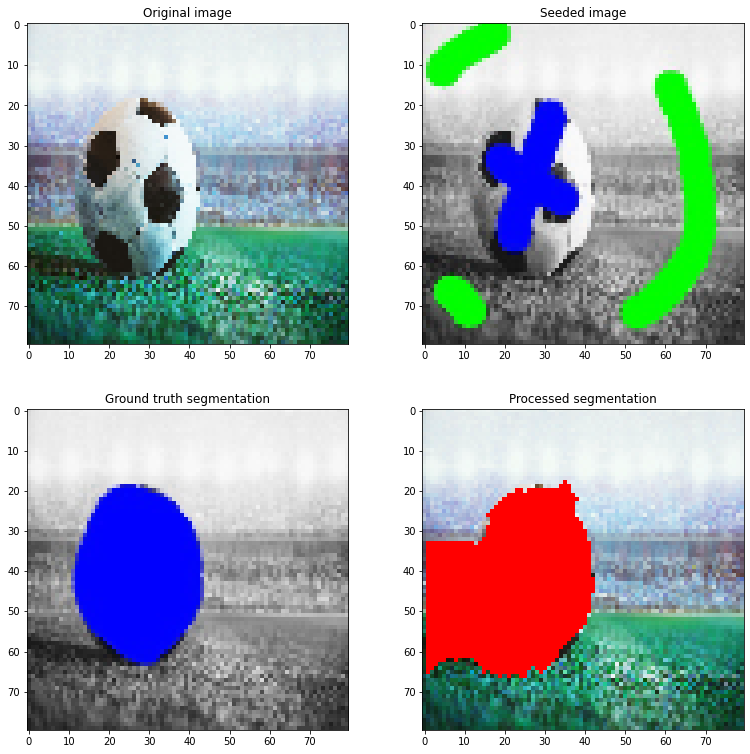

In [ ]:
orig_image,seeded_image,gt_image,gt,img_seg,seg,time_algo=clrShedProcess("images/soccer/soccer.jpg",(80,80),filter_sigma=0.01)
soccer_water_dice=processTestResults(orig_image,seeded_image,gt_image,gt,img_seg,seg,time_algo)

## Horse test

starting processing with shape 80 80
<class 'numpy.ndarray'>
Running time: 0
Dice: 71.53242221576039


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:6: RuntimeWarning: Images with dimensions (M, N, 3) are interpreted as 2D+RGB by default. Use `multichannel=False` to interpret as 3D image with last dimension of length 3.
  


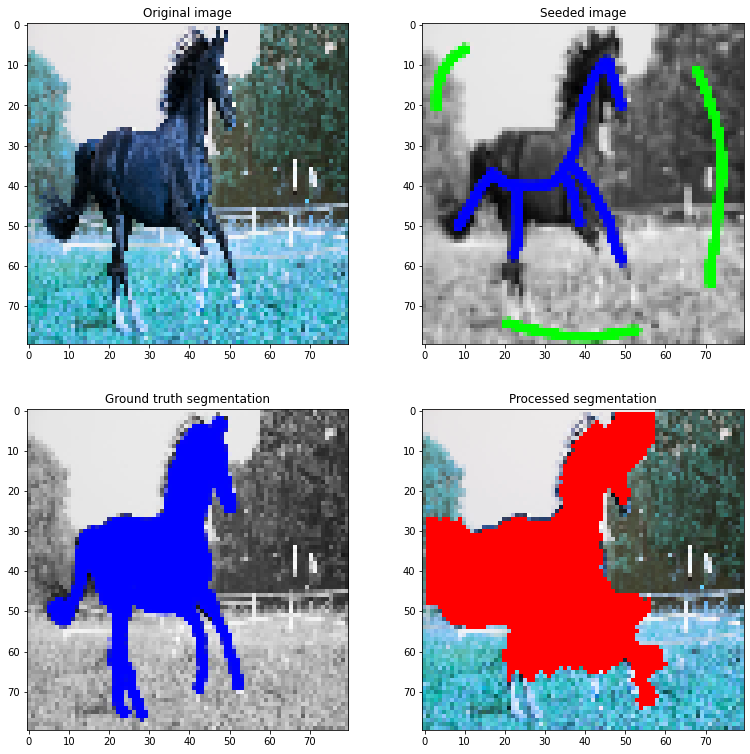

In [ ]:
orig_image,seeded_image,gt_image,gt,img_seg,seg,time_algo=clrShedProcess("images/horse/horse.jpg",(80,80),filter_sigma=0.01)
horse_water_dice=processTestResults(orig_image,seeded_image,gt_image,gt,img_seg,seg,time_algo)

# Methods comparison

In [ ]:

# importing the modules 
from IPython.display import display 
import pandas as pd 
  
# creating a DataFrame 
dict = {'Method' : ['MaxFlow', 'Watershed'], 
        'Circle' : [circle_maxflow_dice, circle_water_dice ], 
        'Horse' : [horse_maxflow_dice, horse_water_dice ], 
        'Soccer' : [soccer_maxflow_dice, soccer_water_dice]} 
df = pd.DataFrame(dict) 

# displaying the DataFrame 
display(df) 

,Method,Circle,Horse,Soccer
0,MaxFlow,98.295716,86.250838,91.345330
1,Watershed,98.375262,71.532422,78.996139
